# Think Bayes
Henry Rachootin


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
import thinkbayes2 as tb
from thinkbayes2 import Suite, Joint, Pmf

import thinkplot as tp

import numpy as np

from scipy.stats import norm,binom

# The Height Problem II

Their height is about 182 cm
It's between 176 and 190 (90% confidence)


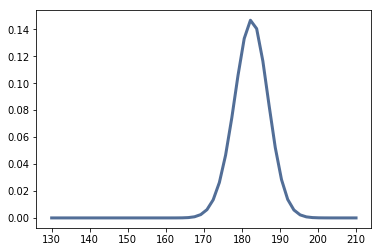

In [2]:
dist_height = dict(male=norm(178, 7.7),
                   female=norm(163, 7.3))
hs = np.linspace(130, 210);
ps = dist_height['male'].pdf(hs);
male = Pmf(dict(zip(hs, ps)));
ps = dist_height['female'].pdf(hs);
female = Pmf(dict(zip(hs, ps)));

h=tb.MakeMixture(Pmf([male,female]));

class Taller(Suite, Joint):
    def Likelihood(self, data, hypo):
        ha,hb=hypo
        if data=='A':
            return 1 if ha>hb else 0
        elif data=='B':
            return 1 if hb>ha else 0

prior = Taller(tb.MakeJoint(h,h));
prior.Update('B');

for i in range(9):
    prior = Taller(tb.MakeJoint(prior.Marginal(0),h))
    prior.Update('A');

tp.Pdf(prior.Marginal(0))

print("Their height is about %.0f cm"%prior.Marginal(0).Mean())
print("It's between %.0f and %.0f (90%% confidence)"%prior.Marginal(0).CredibleInterval())

In [3]:
class Sex(Suite):
    def Likelihood(self, data, hypo):
        return dist_height[hypo].pdf(data);

sexes = [(Sex(['male','female']), h, prior.Marginal(0)[h]) for h in hs];
for sex,h,p in sexes:
    sex.Update(h)

metaPmf = Pmf({pmf:p for pmf,_,p in sexes});

sex = tb.MakeMixture(metaPmf);

print("There is a %.1f chance that they are male"%(sex['male']*100))

There is a 93.5 chance that they are male


# The Lincon Index Problem

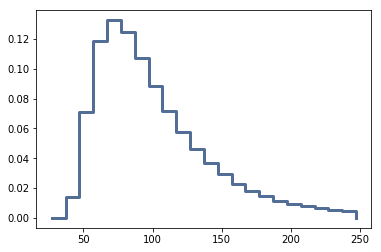

In [5]:
class BugHunt(Suite, Joint):
    def Likelihood(self, data, hypo):
        p1,p2,n = hypo
        k1,k2,c = data
        
        if k1>n or k2>n:
            return 0
        
        l1 = binom(n,   p1).pmf(k1)
        l2 = binom(n-k1,p2).pmf(k2-c)
        l3 = binom(k1,  p2).pmf(c)
        
        return l1*l2*l3
    
ps = np.linspace(0,1,20)

k1=20;
k2=15;
c=3;
minBugs = k1+k2-c;

ns = range(minBugs,250,10)
prior = [(p1,p2,n) for p1 in ps for p2 in ps for n in ns];

#print(prior)

bugs = BugHunt(prior);
bugs.Update((20,15,3));

tp.Pmf(bugs.Marginal(2))


I estimate the mean to be 100, 
and the Lincoln index agrees it should be 100.
0.2347888463387506 0.17882134535064498


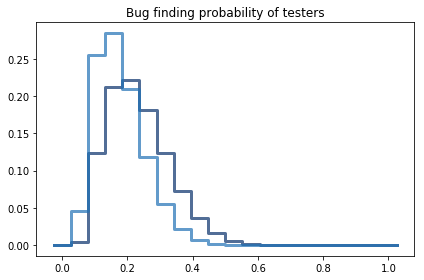

In [18]:
print("I estimate the mean to be %.0f, \nand the Lincoln index agrees it should be %.0f."%(bugs.Marginal(2).Mean(),k1*k2/c))

tp.Pmf(bugs.Marginal(0))
tp.Pmf(bugs.Marginal(1))
tp.decorate(title="Bug finding probability of testers")
print(bugs.Marginal(0).Mean(),bugs.Marginal(1).Mean())

However, I don't like that chunky graph. I had to use big chunks to get it to run on my laptop. I'm gonna do this in mathematica with MCMC.

![](https://i.imgur.com/i3uUN0R.png)

That's better. This gives the mean for the number of bugs at 112, and the mean for the testers' bug finding probabilities at 22.6% and 12.3% respectively. I used the Metropolis-Hasting's algorithm. Here's the source code:

    l[n_, p_, k_] := PDF[BinomialDistribution[n, p], k]
    k1 = 20;
    k2 = 15;
    c = 3;
    MinN = k1 + k2 - c;
    f[p1_, p2_, n_] := l[n, p1, k1]*l[n - k1, p2, k2 - c]*l[k1, p2, c]
    un = UniformDistribution[{0, 1}];
    normP = NormalDistribution[0, .05];
    normN = NormalDistribution[0, 5];
    Clamp[p_] := Min[Max[p, 0], 1]
    ClampN[n_] := Max[Round[n], MinN]
    step[{p1_, p2_, n_}] := With[
      {
       u = RandomVariate[un],
       p1p = Clamp[RandomVariate[normP] + p1],
       p2p = Clamp[RandomVariate[normP] + p2],
       np = ClampN[RandomVariate[normN] + n]
       },
      If[u <= f[p1p, p2p, np]/f[p1, p2, n], {p1p, p2p, np}, {p1, p2, n}]
      ]
    samples = NestList[step, {.23, .17, 100}, 1000000];
    {p1M, p2M, nM} = Transpose@samples;

# The Skeet Problem

There is a 58.3% chance that Rhode is better. That's a Bayes factor of 1.17.


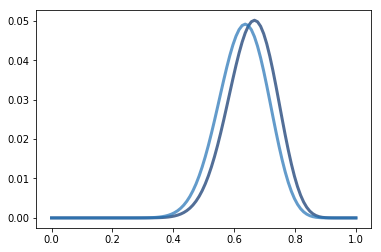

In [37]:
class Shooter(Suite):
    def Likelihood(self, data, hypo):
        p     = hypo;
        n,k   = data;
        return binom(n,p).pmf(k);
    
ps = np.linspace(0,1,100);
R = Shooter(ps);
M = Shooter(ps);
R.Update((25+2+2+2+2,15+1+2+2+2));
M.Update((25+2+2+2+2,15+1+2+2+1));

tp.Pdf(R)
tp.Pdf(M)

joint = tb.MakeJoint(R,M);
pRBetter = 0;
for (pR,pM),p in joint.Items():
    if pR>pM:
        pRBetter += p;
print("There is a %.1f%% chance that Rhode is better. That's a Bayes factor of %.2f."%(pRBetter*100,pRBetter/.5))


win = 0;
tie = 0;
for (pR,pM),p in joint.Items():
    RPMF=tb.MakeBinomialPmf(25,pR)
    MPMF=tb.MakeBinomialPmf(25,pM)
    for nR,pnR in RPMF.Items():
        for nM, pnM in MPMF.Items():
            if(nR>nM):
                win += p*pnR*pnM
            elif(nR==nM):
                tie += p*pnR*pnM

In [42]:
print("There is a %.1f%% chance that Rhode would win a rematch without a tiebreaker, and a %.1f%% chance that they would tie."%(win*100,tie*100))

There is a 52.0% chance that Rhode would win a rematch without a tiebreaker, and a 8.9% chance that they would tie.


In [46]:
wint = 0;
tiet = 0;
for (pR,pM),p in joint.Items():
    RPMF=tb.MakeBinomialPmf(2,pR)
    MPMF=tb.MakeBinomialPmf(2,pM)
    for nR,pnR in RPMF.Items():
        for nM, pnM in MPMF.Items():
            if(nR>nM):
                wint += p*pnR*pnM
            elif(nR==nM):
                tiet += p*pnR*pnM
                
print("In each round of sudden death there is a %.1f%% chance that Rhode would win, \nand a %.1f%% chance that they would tie again."%(wint*100,tiet*100))

In each round of sudden death there is a 32.5% chance that Rhode would win, 
and a 39.3% chance that they would tie again.


To find the total probability of Rhode winning a rematch, we need to sum an infinite series. Again, it was best to switch to mathematica, so here's my code to sum that infinite series:

     {w, t, wt, tt} = {0.5202329045549506, 0.08924107056052635, .3254421768707451, 0.3926984126984103}
     w + t*Sum[wt*tt^n, {n, 0, Infinity}]
Which gives Rhode a total of a 56.8% chance of winning after an arbitrary number of ties. As a reality check I also calculated the probability of Meng winning after arbitrary ties with

     (1 - w - t) + t*Sum[(1 - wt - tt)*tt^n, {n, 0, Infinity}]

And she gets a 43.2% chance of winning. Those add up to one, which is good! They have no chance of tying forever.

# The Social Desirability Problem

There are between 48 and 69 athiests surveyed (90% confidence).
The mean is 59.0


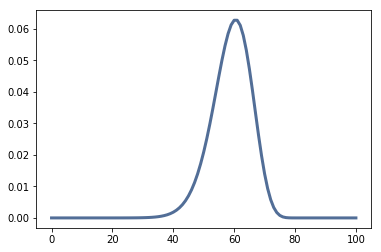

In [53]:
class Athiests(Suite):
    def Likelihood(self, data, hypo):
        nAthiests=hypo
        nYes=data
        if(nAthiests>nYes):
            return 0
        else:
            return binom(100-nAthiests,.5).pmf(nYes-nAthiests)
        
s=Athiests(range(101));
s.Update(80);
tp.Pdf(s)
print("There are between %d and %d athiests surveyed (90%% confidence)."%s.CredibleInterval())
print("The mean is %.1f"%s.Mean())

# The Sleeping Beauty Problem

I've gotta go with 1/2 on this one. The only datum that Sleeping Beauty has is that she was awoken, which she already know would happen. Hence the posteriors are the same as the priors, where the coin has a 50% chance landing heads. 

I don't think that the 1/3 argument on wikipedia is even credible, since it claims that P(Tails | Monday) = P(Monday | Tails), but this assertion fails to account for the prior probabilities. I demonstrate this below with a Bayseian update, which shows that P(Tails | Monday)=1/5 and P(Monday | Tails)=1/3. The wikipedia article cavalierly switches between P(A and B) and P(A|B) but those are not the same. In fact, that's the point of conditional probabilty.

Note that the likelihoods for P(Monday|Tails) and P(Tails|Monday) are the same, but they still lead to different posteriors.

In [93]:
heads = 'heads';
tails = 'tails';
tuesday = 'tuesday';
monday = 'monday';

class Coin(Suite, Joint):
    def Likelihood(self, data, hypo):
        coin,day = hypo
        if(data == monday):
            if(day == tuesday):
                return 0#no chance of this
            if(coin == heads):
                return 1 #the probability of it being monday with heads is 1
            if(coin == tails):
                return 0.5#whereas when waking up with tails it could have been tuesday
        if(data == tails):
            if(coin == heads):
                return 0#no chance of this
            if(day == monday):
                return 0.5#could have been heads or tails
            if(day == tuesday):
                return 1#can only be tails on tuesday
        else:
            return 1
            
        

#Here's how I'm sturcturing my priors. First there is a coin flip, then I'm modeling the lack of information
#about what day it is (in the tails case) as it being equally probable that Sleeping Beauty is awoken on Monday
#or Tuesday.

#             coin flip
#                 |
#             ----------------
#             |              |
#           heads(.5)      tails(.5)
#             |               |
#           Monday(.5)    --------------
#                         |            |
#                     Monday(.25)   Tuesday(.25)

coin = Coin({(heads,tuesday):0 
             ,(heads,monday):.5, 
             (tails,tuesday):.25,
             (tails,monday):.25
            })
coin.Update(monday)
tp.hist(coin.Marginal(0))
print("Probability that the coin landed tails given that it's Monday is: %.2f%%"%(100*coin.Marginal(0)[tails]))

Probability that the coin landed tails given that it's Monday is: 20.00%


Probability that it's Monday given that the coin landed tails is: 33.33%


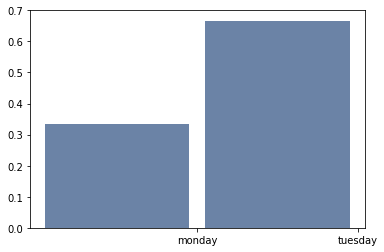

In [94]:
coin = Coin({(heads,tuesday):0,(heads,monday):0.5,(tails,tuesday):.25,(tails,monday):.25})
coin.Update(tails)
tp.hist(coin.Marginal(1))
print("Probability that it's Monday given that the coin landed tails is: %.2f%%"%(100*coin.Marginal(1)[monday]))

# Project Idea

I want to do a project on belief propagation in Bayesian networks. Here's a link to a relevant wikipedia article:
https://en.wikipedia.org/wiki/Belief_propagation

This may look a bit more like a complexity project then a CompBayes project, but oh well, CompBayes wasn't offered this semester.